# Election data

In [895]:
%matplotlib inline
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

## Import data

In [896]:
# Election data from 1976 to 2020
path = 'dataverse_files/1976-2020-president.csv'
election_all = pd.read_csv(path)

In [897]:
# Delete 'notes' column (because all values are 'NA')
election_all.drop(columns=['notes'], inplace=True)

# Rename 'state' column to 'GEONAME' to match census DataFrame
election_all.rename(columns={'state': 'GEONAME'}, inplace=True)

### Data validation

Fill in NaN values

In [898]:
election_all['candidate'].fillna('OTHER', inplace=True)
election_all['party_detailed'].fillna('OTHER', inplace=True)
election_all['party_simplified'].fillna('OTHER', inplace=True)

Rename state names to match census DataFrames

In [899]:
def rename_title(name):
    exceptions = ['of', 'and', 'the', 'on', 'by']
    if type(name) == str:

        s = name.split()
        
        if len(s) > 1:
            new_name = s[0].capitalize()

            for w in s[1:-1]:
                new_name += (" " + w.capitalize()) if w.lower() not in exceptions else (" " + w.lower())

            new_name += (" " + s[-1].capitalize())
            return(new_name.strip())
        else:
            return name.capitalize().strip()
    elif type(name) == list:
        for i, p in enumerate(name):
            s = name[i].split()
            
            if len(s) > 1:
                new_name = s[0].capitalize()

                for w in s[1:-1]:
                    new_name += (" " + w.capitalize()) if w.lower() not in exceptions else (" " + w.lower())

                new_name += (" " + s[-1].capitalize())
                name[i] = new_name.strip()
            else:
                name[i] = s[0].capitalize().strip()
        return name
    else:
        return None

In [900]:
# Rename state names to match census DataFrame
for s in election_all['GEONAME'].value_counts().index.tolist():
    election_all.replace(to_replace={'GEONAME': {s: rename_title(s)}}, inplace=True)

## Fetch data

### Get winner (or loser) of an election in a certain state in a certain year

In [901]:
election_year = 2012
state = 'Pennsylvania'
reverse = True # Set to false to find loser (second place)

In [902]:
reverse = 0 if reverse else 1
state = rename_title(state)
election_1976 = election_all[election_data_all['year']==election_year]
g = election_1976.groupby('GEONAME')

g.get_group(state).sort_values('candidatevotes').sort_values('candidatevotes', ascending=False).iloc[[reverse]]

,year,GEONAME,state_po,state_fips,state_cen,state_ic,office,candidate,party_detailed,writein,candidatevotes,totalvotes,version,party_simplified
3319,2012,Pennsylvania,PA,42,23,14,US PRESIDENT,"OBAMA, BARACK H.",DEMOCRAT,False,2990274,5742040,20210113,DEMOCRAT


### Get percentages for candidates

In [903]:
election_year = 2020
state = 'District of Columbia'

In [904]:
state = rename_title(state)
t1 = election_all[(election_all['year']==election_year) & (election_all['GEONAME']==state)]
totalvotes = t1['totalvotes'].values[0]
t2 = t1[['year', 'GEONAME', 'state_po', 'candidate', 'party_detailed', 'candidatevotes']]

pd.options.display.float_format = "{:,.4f}".format
print('Total votes:', totalvotes)

t2['percentage'] = t2['candidatevotes'] / totalvotes
t2.sort_values(by='percentage', ascending=False)

Total votes: 344356


,year,GEONAME,state_po,candidate,party_detailed,candidatevotes,percentage
3842,2020,District of Columbia,DC,"BIDEN, JOSEPH R. JR",DEMOCRAT,317323,0.9215
3843,2020,District of Columbia,DC,"TRUMP, DONALD J.",REPUBLICAN,18586,0.0540
3847,2020,District of Columbia,DC,OTHER,OTHER,3137,0.0091
3844,2020,District of Columbia,DC,"JORGENSEN, JO",LIBERTARIAN,2036,0.0059
3845,2020,District of Columbia,DC,"HAWKINS, HOWIE",DC STATEHOOD GREEN,1726,0.0050
3846,2020,District of Columbia,DC,"LA RIVA, GLORIA ESTELLA",INDEPENDENT,855,0.0025
3848,2020,District of Columbia,DC,"PIERCE, BROCK",INDEPENDENT,693,0.0020


### Graph

In [908]:
# Get graph of voter counts for this state
state = 'Montana'

In [909]:
election_all['year'].to_numpy()

group = election_all[election_all['GEONAME']==state].groupby('year')

years = []
totalvotes = []

for key, value in group:
    years.append(key)
    totalvotes.append(value['totalvotes'].iloc[0])
#     print(key, '\n', value['totalvotes'].iloc[0])

Generate chart

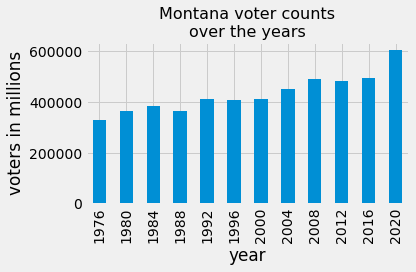

In [910]:
plt.style.use("fivethirtyeight")
pd.DataFrame(data=totalvotes, index=years).plot(legend=None, kind='bar')
plt.title('{} voter counts\nover the years'.format(state), fontsize=16)
plt.xlabel("year")
plt.ylabel("voters in millions")
plt.tight_layout()

### Pie chart

In [989]:
election_year = 2012
state = 'New Jersey'
by_simplified_party_name = False # Set to false for results with detailed party names (no 'OTHER')
only_top_x = 3 # See only top x number of parties in the pie chart
format_party_names = True # Set to true to change party names to title case

In [994]:
filter_by_simplified_party_name = 'party_simplified' if by_simplified_party_name else 'party_detailed'

election_results = election_all.groupby(['year', 'GEONAME']).get_group((election_year, state)).sort_values('candidatevotes', ascending=False)

parties = election_results[filter_by_simplified_party_name].values.tolist()
votes = election_results['candidatevotes'].tolist()

if by_simplified_party_name:
    votes = votes[:len(parties)]
    
    # account for other votes
    votes[-1] = election_results[['party_simplified', 'candidatevotes']].groupby('party_simplified').get_group(('OTHER'))['candidatevotes'].sum()

# only show top x number of parties in pie chart
parties = parties[:only_top_x]
votes = votes[:only_top_x]

if format_party_names:
    parties = rename_title(parties)

Generate pie chart

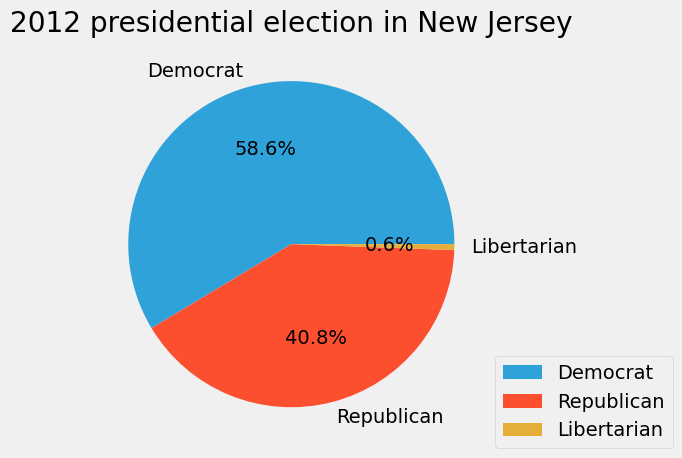

In [995]:
plt.style.use("fivethirtyeight")
# Republicans will be red, Democrats will be blue
colors = ['#30a2da', '#fc4f30', '#e5ae38', '#6d904f', '#8b8b8b']
if parties[0] == 'Republican':
    colors[0], colors[1] = colors[1], colors[0]

plt.pie(votes, labels=parties, textprops={'fontsize': 14}, autopct='%1.1f%%', colors=colors)
plt.title("{} presidential election in {}".format(election_year, state))
plt.legend(parties[:only_top_x], loc=(1, 0))
plt.tight_layout()